In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import requests
import seaborn as sns
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from datetime import timedelta
from sklearn import preprocessing
from IPython.display import display
import operator

In [2]:
df = pd.read_csv('ks-projects-201801.csv',error_bad_lines=False)

b'Skipping line 20454: expected 15 fields, saw 19\nSkipping line 27266: expected 15 fields, saw 23\nSkipping line 47738: expected 15 fields, saw 19\nSkipping line 54556: expected 15 fields, saw 23\n'
b'Skipping line 75000: expected 15 fields, saw 17\nSkipping line 95465: expected 15 fields, saw 21\nSkipping line 102283: expected 15 fields, saw 26\nSkipping line 129576: expected 15 fields, saw 26\n'
b'Skipping line 170525: expected 15 fields, saw 16\nSkipping line 177348: expected 15 fields, saw 26\n'
b'Skipping line 204638: expected 15 fields, saw 19\nSkipping line 211470: expected 15 fields, saw 26\nSkipping line 218306: expected 15 fields, saw 16\nSkipping line 252430: expected 15 fields, saw 17\nSkipping line 259262: expected 15 fields, saw 26\n'
b'Skipping line 266098: expected 15 fields, saw 18\nSkipping line 300233: expected 15 fields, saw 17\nSkipping line 307065: expected 15 fields, saw 27\nSkipping line 313893: expected 15 fields, saw 19\n'
b'Skipping line 348033: expected 15 

# Classes and Functions

In [3]:
-

In [4]:
def BoxHist(column, df_focus, bins=10, titleVal=False):
    
    sns.set()
    colList = df_focus[column]
    
    if not titleVal:
        titleVal = '\"{}\"'.format(column)
    plotTitle = 'Values for {}'.format(titleVal)
    
    # plots
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(y=column, data=df_focus)
    
    plt.subplot(1, 2, 2)
    g=sns.distplot(colList, kde=False, bins=bins)
    
    # rotate label for large tick values on histagram x axis
    if (colList.max() > 9999):
        plt.setp(g.get_xticklabels(), rotation=45)

    plt.suptitle(plotTitle)
    plt.show()

In [5]:
def GridSearchTablePlot(gridClf, paramName,
                          num_results=15,
                          negative=False,
                          graph=True,
                          displayAllParams=False,
                          largeTable=False):

    clf = gridClf.best_estimator_
    clf_params = gridClf.best_params_
    if negative:
        clf_score = -gridClf.best_score_
    else:
        clf_score = gridClf.best_score_
    clf_stdev = gridClf.cv_results_['std_test_score'][gridClf.best_index_]
    cv_results = gridClf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if displayAllParams:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + paramName]

 
    # display abreviated top 'num_results' results
    if largeTable:
        display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    else:
        abrevCols = ['mean_test_score','std_test_score']
        abrevCols += [col for col in pd.DataFrame(cv_results) if 'param_' in col]
    
        display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results)[abrevCols])
        

    # plot the results
    [col for col in pd.DataFrame(cv_results) if 'param_' in col]
    
    scores_df = scores_df.sort_values(by='param_' + paramName)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + paramName]

    # plot
    if graph:
        plt.figure(figsize=(8, 4))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(paramName + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(paramName)
        plt.ylabel('Score')
        plt.show()

In [6]:
import time
from sklearn.model_selection import cross_val_score

class Model(object):
    
    def __init__(self,name,X,Y,modelObj,**modelParams):
        self.params = modelParams
        self.modelObj = modelObj.set_params(**self.params)  
        self.name = name
        self.X = X
        self.Y = Y
        self.initValues()   
    
    def initValues(self):
        start = time.time()
        self.modObjFit = self.modelObj.fit(self.X, self.Y)
        end = time.time()
        self.timeToFit = end - start
        self.crossVal = cross_val_score(self.modelObj, self.X, self.Y, cv=5)
        self.crossValMean = np.mean(self.crossVal)
        self.crossValRange = max(self.crossVal) - min(self.crossVal)
         
    def performance(self, boxPlot=True):
        print ("Model:\t\t" + str(self.name))
        print ("CV Mean:\t" + str(self.crossValMean))
        print ("CV Range:\t" + str(self.crossValRange))
        print ("Train Time:\t" + str(self.timeToFit))
        print ("CV Scores: ")
        print (self.crossVal)
        if boxPlot:
            fig = plt.figure()
            title = "Performance: %s" % (self.name)
            fig.suptitle(title)
            ax = fig.add_subplot(111)
            plt.boxplot(self.crossVal, showmeans=True)
            ax.set_xticklabels(self.name)
            plt.show()
    
    def compareBox(self,modelList,filterResult=0, newTitle=''):
        results = []
        names = []
        
        results.append(self.crossVal)
        names.append(self.name)
        
        for rightModel in modelList:
            if filterResult > 0:
                if rightModel.crossVal.mean() > filterResult:
                    results.append(rightModel.crossVal)
                    names.append(rightModel.name)
            else:
                results.append(rightModel.crossVal)
                names.append(rightModel.name)
        
        fig = plt.figure()
        if newTitle != '':
            title = newTitle
        else:
            title = "Performance: %s" % (self.name)
        fig.suptitle(title)
        ax = fig.add_subplot(111)
        
        plt.boxplot(results, showmeans=True)
        ax.set_xticklabels(names)
        plt.setp(ax.get_xticklabels(), rotation=90)
        plt.show()
        
    def fullCompareList(self,listOfModels,folds=False):
        listOfModels.insert(0,self)
        dfout = pd.DataFrame()
        dataForFrame = []
        cvNameList= []
        for model in listOfModels:
            dataRowForFrame = {}
            dataRowForFrame = {'Name': model.name,
                                'Time':model.timeToFit,
                                'CV Mean':model.crossValMean,
                                'CV Range': model.crossValRange}
            if folds:  
                buildCvNameList = False
                if not cvNameList:
                    buildCvNameList=True
                for idx,cv in enumerate(model.crossVal):
                    cvName = 'CV Fold ' + str(idx+1)
                    if buildCvNameList:
                        cvNameList.append(cvName)
                    dataRowForFrame[cvName] = cv
            dataForFrame.append(dataRowForFrame)
        colOrder = ['Name', 'CV Mean', 'CV Range', 'Time']
        colOrder += cvNameList  
        dfOut = pd.DataFrame(dataForFrame)
        dfOut = dfOut[colOrder]
        display(dfOut)
        lgrbg = listOfModels.pop(0)
        self.compareBox(listOfModels)    

# Data Set Information


https://www.kaggle.com/kemical/kickstarter-projects

In [7]:
df=df.sample(10000, random_state=32)

In [8]:
df.shape

(10000, 15)

In [9]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
711859,292924641,"NextGen, Use any platform on any devive, rules...",Software,Technology,SEK,2014-11-04,50000,2014-10-21 15:14:46,0,failed,0,SE,0,0.00,6726.22
443026,1865145137,Cassidy Jones Adventures: Paperback Books For ...,Fiction,Publishing,USD,2012-07-12,1000,2012-06-28 01:35:01,1505,successful,43,US,1505,1505.00,1000.00
305960,1549399998,· Guenda · products for connecting with nature...,Embroidery,Crafts,MXN,2017-12-25,60000.00,2017-11-25 15:56:14,60520.00,successful,84,MX,112.64,3067.57,3041.21
56190,1111918633,The ABCs of Nightmares,Children's Books,Publishing,CAD,2016-11-24,8500.00,2016-10-24 01:05:08,2764.00,failed,49,CA,0,2048.77,6300.50
867977,7.40164e+08,The Toughest,Documentary,Film & Video,USD,2016-04-02,2295.00,2016-03-03 15:46:40,0.00,failed,0,US,0,0.00,2295.00


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 711859 to 1038110
Data columns (total 15 columns):
ID                  10000 non-null object
name                10000 non-null object
category            10000 non-null object
main_category       10000 non-null object
currency            10000 non-null object
deadline            10000 non-null object
goal                10000 non-null object
launched            10000 non-null object
pledged             9999 non-null object
state               9999 non-null object
backers             9999 non-null object
country             9999 non-null object
usd pledged         9897 non-null object
usd_pledged_real    9999 non-null float64
usd_goal_real       9999 non-null float64
dtypes: float64(2), object(13)
memory usage: 1.2+ MB


# Data Cleaning

Since we have such a large data set most of the cleaning will be handled by dropping the data rather than imputing.

## Drop Columns

### Outcome Related, Duplicate and Identifiers

"pledged" and "backers" are outcome variables (i.e. they are not known until the end of the campaign). These may be used to determine the popularity of a campaign or the magnitude of success. For this effort, though, we are trying to predict the outcome.  These variables would not be available until the outcome has occurred. 

Other columns contain money amounts related to the campaign.  We will just be using the US Dollar as the standard for the goal money amounts.  This is contained in the "usd_goal_real" variable. The other money columns can be dropped.  Adios pesos. 

Identifiers columns such as "ID" and "name" are not needed either so this will be dropped as well.


In [11]:
dfDropCols = df.copy()
dfDropCols = dfDropCols.drop(['usd pledged',
                              'usd_pledged_real',
                              'pledged',
                              'backers',
                              'goal',
                              'currency',
                              'name',
                              'ID'], axis=1)

## Drop Rows

### Null Values

There are very few nulls. 

In [12]:
total = dfDropCols.isnull().sum().sort_values(ascending=False)
percent = (dfDropCols.isnull().sum()/dfDropCols.isnull().count()).sort_values(ascending=False)
dfDropCols_missingData = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
display(dfDropCols_missingData.head(20))
dfDropCols.isnull().sum().max()

,Total,Percent
usd_goal_real,1,0.0001
country,1,0.0001
state,1,0.0001
launched,0,0.0000
deadline,0,0.0000
main_category,0,0.0000
category,0,0.0000


1

In [13]:
dfNoNulls = dfDropCols.copy()
dfNoNulls.dropna(inplace=True)
print ("Before Dropping Nulls: ", dfDropCols.shape[0])
print ("After Dropping Nulls: ", dfNoNulls.shape[0])
print ("Rows Removed: ", dfDropCols.shape[0] - dfNoNulls.shape[0])
print ("Percent Removed: {:.0%}".format(1-(dfNoNulls.shape[0])/dfDropCols.shape[0]))   

Before Dropping Nulls:  10000
After Dropping Nulls:  9999
Rows Removed:  1
Percent Removed: 0%


### Campaigns Not Success or Failure

We are only interested in the campaigns that succeeded or failed so dropping campaign in any other state.

In [16]:
dfDropState = dfNoNulls.copy()
dropVals = ['live',
            'suspended',
            'canceled',
            'fnceled',
            'undefined']
for dv in dropVals:
    dfDropState = dfDropState.drop(dfDropState[(dfDropState['state'] == dv)].index)

print ("Before Dropping: ", dfNoNulls.shape[0])
print ("After Dropping: ", dfDropState.shape[0])
print ("Rows Removed: ", dfNoNulls.shape[0] - dfDropState.shape[0])
print ("Percent Removed: {:.0%}".format(1-(dfDropState.shape[0])/dfNoNulls.shape[0]))       

Before Dropping:  9999
After Dropping:  8794
Rows Removed:  1205
Percent Removed: 12%


In [17]:
# fix index
dfDropState.reset_index(inplace=True, drop=True)

### Convert Date Data

The "launched" and "deadline" variables will need to be "datetime" type.

In [18]:
dfDates = dfDropState.copy()
dfDates[['launched','deadline']] = dfDates[['launched','deadline']].apply(pd.to_datetime)

# Univariate Exploration

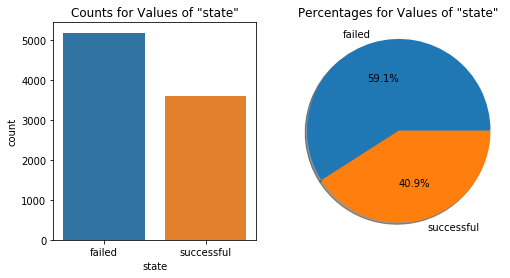

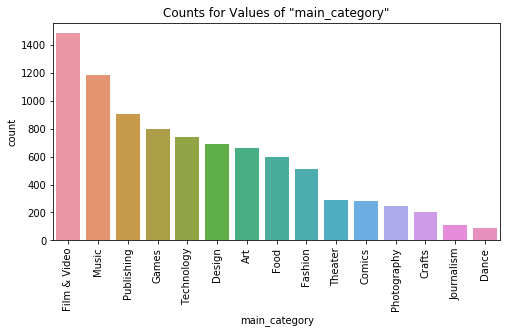

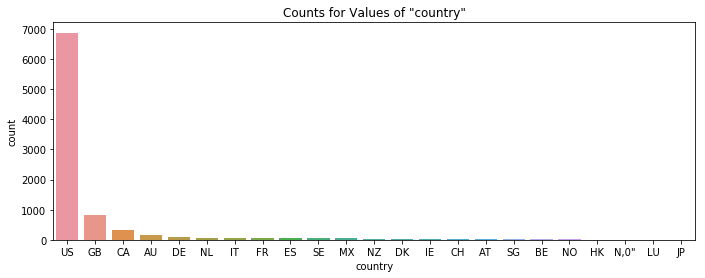

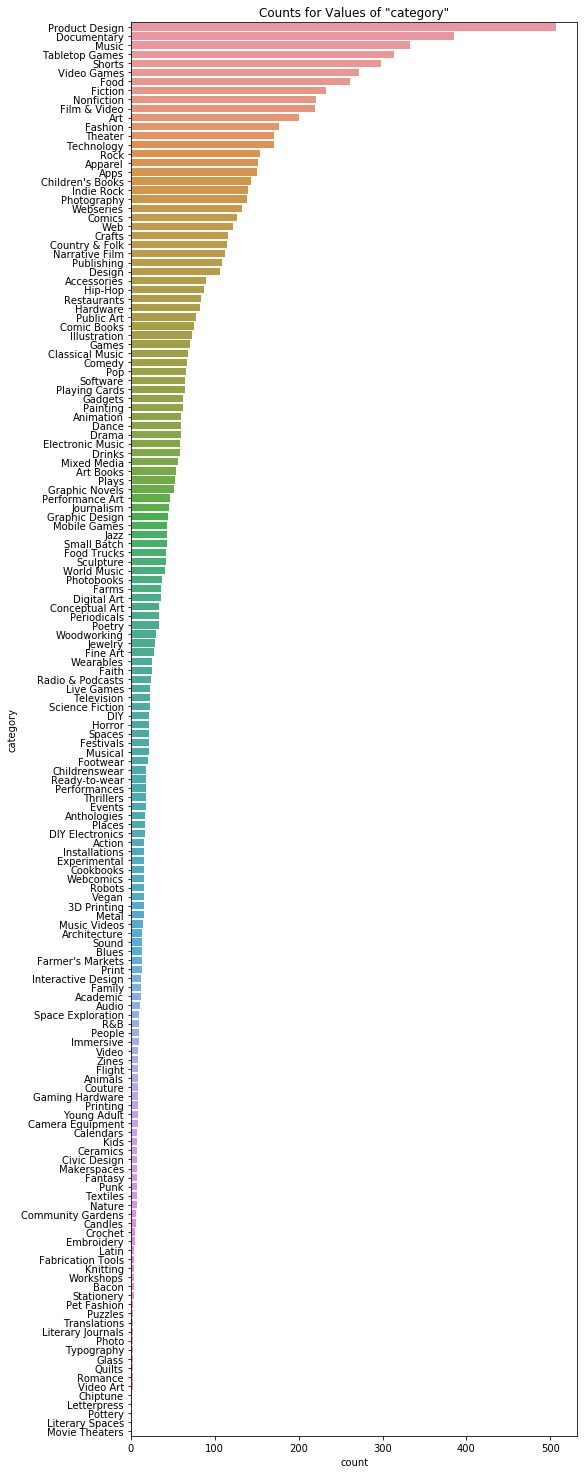

In [19]:
catCols = ['state','main_category','country','category']
for col in catCols:
    BarsAndPies(col,dfDates)

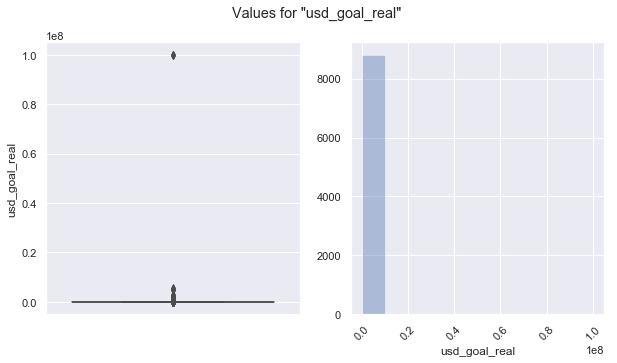

In [20]:
BoxHist('usd_goal_real',dfDropState)

# Feature Creation

In [21]:
dfBuildFeats = dfDropState.copy()

## State Encoding
Success of failure will be encoded as "1" and "0" for modeling.

In [22]:
dfBuildFeats['state'] = dfBuildFeats.state.astype('category')
dfBuildFeats['state_code'] = np.where(dfBuildFeats['state'].str.contains('successful'),1,0)

## Length of Campaign Calculation

The "launched" and "deadline" variables will be utilezed to determine the length of a Kickstarter campaign

In [23]:
dfBuildFeats['CampaignLength'] = (pd.to_datetime(dfBuildFeats['deadline']) 
                           - pd.to_datetime(dfBuildFeats['launched'])).dt.days + 1

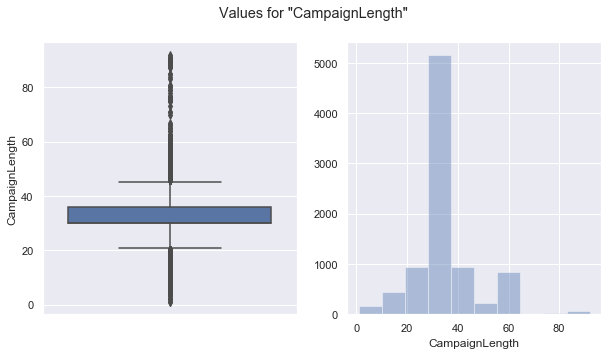

In [24]:
BoxHist('CampaignLength', dfBuildFeats)

## Subcategory Convert to Numerical

There are too many subcategories to do one hot encoding for.  This would result in too many features.  Instead the values will be converted to numerical values.

In [25]:
le = preprocessing.LabelEncoder()
le.fit(dfBuildFeats['category'])
ar = le.transform(dfBuildFeats['category'])
dfBuildFeats['num_category'] = ar

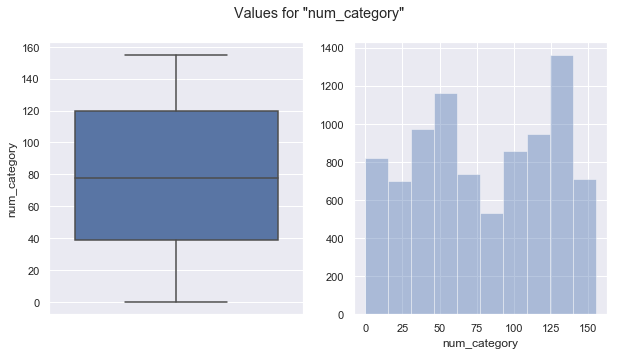

In [26]:
BoxHist('num_category',dfBuildFeats)

## Country US or Not

The US has the most campaigns by far.  This feature will combine all other countries into a single value.  The feature will indicate whether the campaign took place in the US or not.

In [27]:
dfBuildFeats['US'] = np.where(dfBuildFeats['country'].str.contains('US'),1,0)

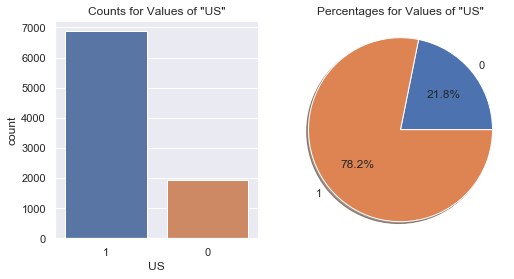

In [28]:
BarsAndPies('US',dfBuildFeats)

## Category One Hot Encoding
Categories values will converted to columns and assigned a True/False based on whether the row belongs to that category or not.

In [29]:
dfEnc = dfBuildFeats.copy()
dfEnc = pd.get_dummies(dfEnc, columns=['main_category'], prefix = ['cat'])

# Create Final Feature Set
Drop all variables that will not be used in the models.

In [30]:
dfFeats = dfEnc.copy()
dfFeats = dfFeats.drop(['category',
                        'deadline',
                        'launched',
                        'state',
                        'country'],axis=1)

# Set Data and Target

In [31]:
y=dfFeats['state_code']
X=dfFeats.drop('state_code', axis=1)

In [32]:
y.unique()

array([0, 1])

In [33]:
X.shape

(8794, 19)

In [34]:
X.head()

,usd_goal_real,CampaignLength,num_category,US,cat_Art,cat_Comics,cat_Crafts,cat_Dance,cat_Design,cat_Fashion,cat_Film & Video,cat_Food,cat_Games,cat_Journalism,cat_Music,cat_Photography,cat_Publishing,cat_Technology,cat_Theater
0,6726.22,14,130,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1000.00,14,54,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3041.21,30,43,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,6300.50,31,19,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2295.00,30,39,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


# Baseline

In [35]:
from collections import Counter
counts = Counter(y)
baseline = counts[1]/len(y)
print ("BASELINE: {}".format(baseline))

BASELINE: 0.40948373891289513


# Tuning

### Ridge

Fitting 3 folds for each of 50 candidates, totalling 150 fits
best parameters: {'C': 0.00029902040816326533, 'penalty': 'l2'}
best score:      0.59541 (+/-0.00327)


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    5.1s finished


,mean_test_score,std_test_score,param_C,param_penalty
1,0.595406,0.003266,0.00029902,l2
2,0.595406,0.003266,0.000449041,l2
3,0.595406,0.003266,0.000599061,l2
4,0.595292,0.003134,0.000749082,l2
24,0.595179,0.003123,0.00374949,l2
29,0.595179,0.003123,0.00449959,l2
30,0.595179,0.003123,0.00464961,l2
31,0.595179,0.003123,0.00479963,l2
32,0.595179,0.003123,0.00494965,l2
33,0.595179,0.003123,0.00509967,l2


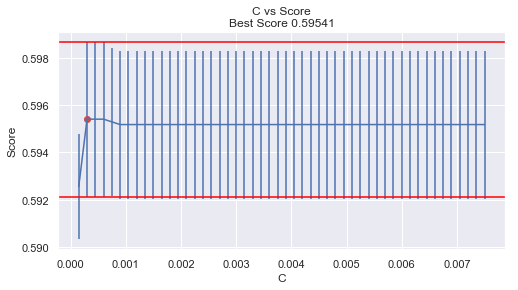

In [36]:
ridgeParams = {'C':np.linspace(.000149,.0075,50),
              'penalty':('l2',)}
lrlrd = GridSearchCV(LogisticRegression(), 
                     ridgeParams, 
                     return_train_score=True, 
                     verbose=True)
gslrd = lrlrd.fit(X,y)
GridSearchTablePlot(gslrd,"C")

## Loop Through C Vals

In [37]:
def loopLogRegCs(X,y,listOfCs,verbose=False,penalty='l2'):

    for c in listOfCs:

        IterRdgLr = LogisticRegression(C=c, penalty=penalty).fit(X,y)
        score = IterRdgLr.score(X,y)
        cvs = cross_val_score(IterRdgLr, X,y, cv=5)
        # Display.
        if verbose:
            print('===========================')
        print("C:{0}\n Score:{1}".format(c,score))
        print (" CVS:\n  {}".format(cvs))
        if verbose:
            print('\nCoefficients:')
            print(IterRdgLr.coef_)
            print('\nIntercept:')
            print(IterRdgLr.intercept_)

            pred_y_sklearn = IterRdgLr.predict(X)
            print('\nAccuracy CrossTab:')
            print(pd.crosstab(pred_y_sklearn, y))

In [38]:
loopCs = [.0000003,3,300000]
loopLogRegCs(X,y,loopCs)

C:3e-07
 Score:0.592335683420514
 CVS:
  [ 0.59034091  0.59067652  0.59067652  0.59101251  0.59044369]
C:3
 Score:0.6026836479417785
 CVS:
  [ 0.59602273  0.60318363  0.5997726   0.60238908  0.60921502]
C:300000
 Score:0.6026836479417785
 CVS:
  [ 0.59602273  0.60318363  0.5997726   0.60238908  0.60921502]


## Perform Ridge Directly

In [39]:
rdgLr1 = LogisticRegression(C=.000003, penalty='l2')
print(rdgLr1)
cross_val_score(rdgLr1, X,y, cv=10)

LogisticRegression(C=3e-06, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


array([ 0.59477866,  0.60113636,  0.59431818,  0.61205916,  0.59499431,
        0.60750853,  0.59044369,  0.60182025,  0.60182025,  0.60182025])

In [40]:
rdgLr1 = LogisticRegression(C=300, penalty='l2')
print(rdgLr1)
cross_val_score(rdgLr1, X,y, cv=10)

LogisticRegression(C=300, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


array([ 0.60045403,  0.60227273,  0.60113636,  0.60864619,  0.59499431,
        0.61774744,  0.59954494,  0.60637088,  0.59954494,  0.60864619])

### Lasso

best parameters: {'C': 0.095000000000000001, 'penalty': 'l1'}
best score:      0.64726 (+/-0.00782)


,mean_test_score,std_test_score,param_C,param_penalty
94,0.647259,0.007821,0.095,l1
86,0.646918,0.006607,0.087,l1
96,0.646918,0.007027,0.097,l1
90,0.646463,0.007200,0.091,l1
93,0.646463,0.006744,0.094,l1
99,0.646463,0.006481,0.1,l1
91,0.646350,0.007130,0.092,l1
92,0.646122,0.007479,0.093,l1
95,0.646122,0.007200,0.096,l1
97,0.645895,0.006349,0.098,l1


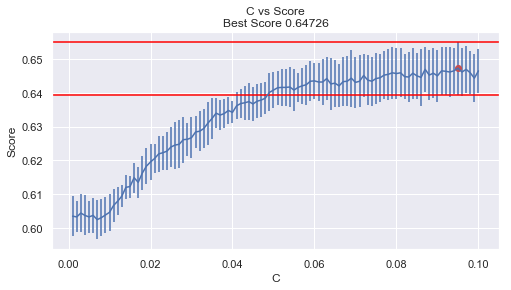

In [41]:
lassoParams = {'C':np.linspace(.001,.1,100),
              'penalty':('l1',)}
gslsr = GridSearchCV(LogisticRegression(), 
                     lassoParams, 
                     return_train_score=True)
gsOut = gslsr.fit(X,y)
GridSearchTablePlot(gslsr,"C", negative=False)

best parameters: {'C': 0.12016949152542372, 'penalty': 'l1'}
best score:      0.64669 (+/-0.00855)


,mean_test_score,std_test_score,param_C,param_penalty
14,0.646691,0.008555,0.120169,l1
24,0.646577,0.010507,0.204576,l1
21,0.646350,0.010763,0.179254,l1
11,0.646350,0.006866,0.0948475,l1
12,0.646236,0.005871,0.103288,l1
59,0.646122,0.011051,0.5,l1
35,0.646122,0.011184,0.297424,l1
20,0.646009,0.009322,0.170814,l1
16,0.645895,0.009680,0.137051,l1
29,0.645895,0.009680,0.24678,l1


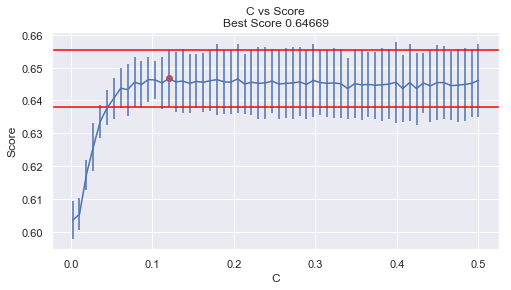

In [42]:
lassoParams = {'C':np.linspace(.002,.5,60),
              'penalty':('l1',)}
gslsr = GridSearchCV(LogisticRegression(), 
                     lassoParams, 
                     return_train_score=True)
gsOut = gslsr.fit(X,y)
GridSearchTablePlot(gslsr,"C", negative=False)

### KNN

best parameters: {'n_neighbors': 2}
best score:      0.59529 (+/-0.00822)


,mean_test_score,std_test_score,param_n_neighbors
1,0.595292,0.008223,2
5,0.595292,0.004540,6
6,0.593700,0.003158,7
3,0.593473,0.005458,4
4,0.589379,0.006651,5
2,0.582443,0.005937,3
0,0.567773,0.007076,1


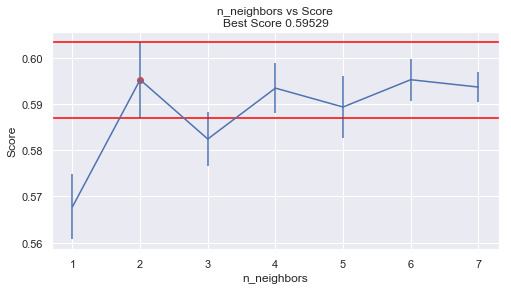

In [43]:
knnParams = {'n_neighbors':range(1,8)}
gsknn=GridSearchCV(KNeighborsClassifier(),
                   knnParams,
                   return_train_score=True, 
                   n_jobs=4)
gsknn.fit(X,y)
GridSearchTablePlot(gsknn,"n_neighbors", negative=False)

### Decision Tree

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=4)]: Done 456 tasks      | elapsed:    4.7s


best parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 17}
best score:      0.64760 (+/-0.00223)


[Parallel(n_jobs=4)]: Done 972 out of 972 | elapsed:    8.5s finished


,mean_test_score,std_test_score,param_criterion,param_max_depth,param_max_features
286,0.647601,0.002229,gini,9,17
136,0.647487,0.009428,entropy,10,11
296,0.647373,0.011577,gini,10,9
292,0.646918,0.004570,gini,10,5
117,0.646805,0.000809,entropy,9,10
84,0.646691,0.007537,entropy,7,13
83,0.646463,0.005282,entropy,7,12
140,0.646350,0.012151,entropy,10,15
125,0.646122,0.010384,entropy,9,18
124,0.646009,0.007829,entropy,9,17


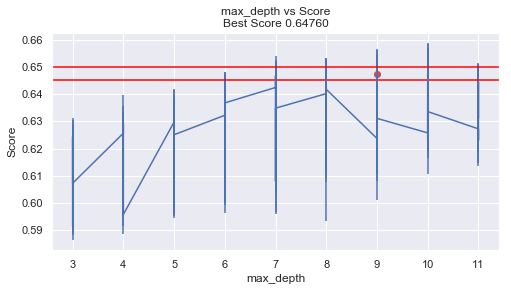

In [44]:
dtparams = {'max_features': range(1,len(X.columns)),
         'max_depth': range(3,12),
         'criterion':('entropy','gini')}
dtgs = GridSearchCV(tree.DecisionTreeClassifier(), 
                    dtparams, 
                    return_train_score=True, 
                    n_jobs=4,
                    verbose=True)
dtgs.fit(X,y)
GridSearchTablePlot(dtgs,"max_depth", negative=False)

### Random Forest

In [45]:
rfparams = {'n_estimators':range(15,25),
        'max_features': range(1,len(X.columns)),
         'max_depth': range(15,25),
         'criterion':('entropy','gini')}
rfgs = GridSearchCV(ensemble.RandomForestClassifier(), 
                    rfparams, 
                    return_train_score=True, 
                    n_jobs=4,
                    verbose=True)
rfgs.fit(X,y)

Fitting 3 folds for each of 3600 candidates, totalling 10800 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   56.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  8.6min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 10.7min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed: 14.1min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed: 16.8min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed: 18.9min
[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed: 21.1min
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed: 23.7min
[Parallel(n_jobs=4)]: Done 10800 out of 10800 | elapsed: 25.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_estimators': range(15, 25), 'max_features': range(1, 19), 'max_depth': range(15, 25), 'criterion': ('entropy', 'gini')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

best parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 2, 'n_estimators': 19}
best score:      0.66409 (+/-0.00677)


,mean_test_score,std_test_score,param_criterion,param_max_depth,param_max_features,param_n_estimators
14,0.664089,0.006773,entropy,15,2,19
1806,0.663179,0.003364,gini,15,1,21
1801,0.662725,0.007776,gini,15,1,16
34,0.662042,0.005545,entropy,15,4,19
59,0.661929,0.003721,entropy,15,6,24
6,0.661929,0.003017,entropy,15,1,21
39,0.661815,0.004828,entropy,15,4,24
1829,0.661701,0.003129,gini,15,3,24
80,0.661246,0.004328,entropy,15,9,15
99,0.661246,0.003539,entropy,15,10,24


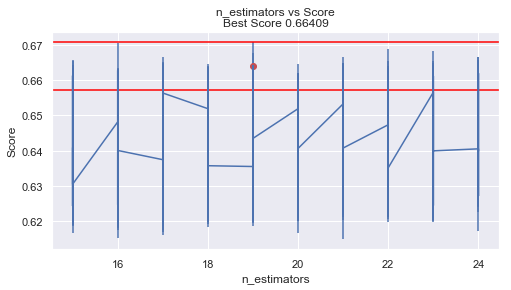

In [46]:
GridSearchTablePlot(rfgs,"n_estimators", negative=False)

### SVM

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   23.0s finished


best parameters: {'C': 1}
best score:      0.59450 (+/-0.01070)


,mean_test_score,std_test_score,param_C
0,0.594496,0.010696,1
4,0.593245,0.010503,5
3,0.592449,0.011696,4
1,0.592336,0.012169,2
2,0.590857,0.011850,3


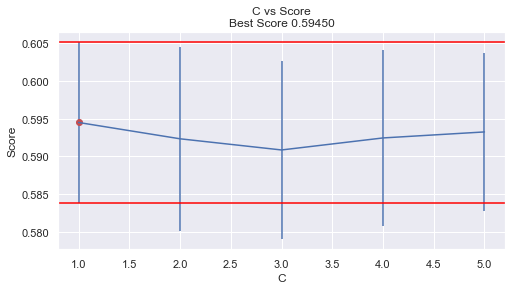

In [47]:
svcParams = {'C':range(1,6)}
svcgs = GridSearchCV(SVC(), 
                     svcParams, 
                     return_train_score=True, 
                     n_jobs=4,
                    verbose=True)
svcgs.fit(X,y)
GridSearchTablePlot(svcgs,"C", negative=False)

### Gradient Boost

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.6s
[Parallel(n_jobs=4)]: Done 192 out of 192 | elapsed:  1.2min finished


best parameters: {'loss': 'deviance', 'max_depth': 4, 'n_estimators': 132}
best score:      0.67990 (+/-0.00494)


,mean_test_score,std_test_score,param_loss,param_max_depth,param_n_estimators
19,0.679895,0.004937,deviance,4,132
11,0.679099,0.007969,deviance,3,132
9,0.679099,0.006632,deviance,3,128
18,0.678986,0.004337,deviance,4,130
10,0.678872,0.008057,deviance,3,130
16,0.678872,0.004013,deviance,4,126
14,0.678758,0.007900,deviance,3,138
17,0.678645,0.004173,deviance,4,128
15,0.678645,0.008295,deviance,3,140
13,0.678645,0.007592,deviance,3,136


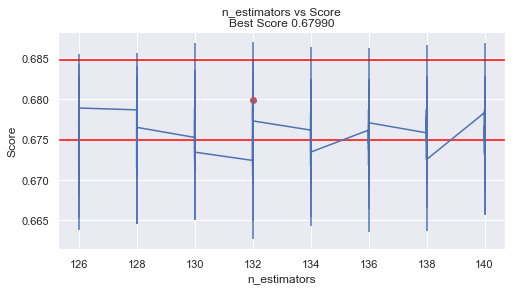

In [48]:
gbparams = {'n_estimators':range(126,142,2),
         'max_depth': range(2,6),
         'loss':('deviance','exponential')}
gbgs = GridSearchCV(ensemble.GradientBoostingClassifier(), 
                    gbparams, 
                    return_train_score=True, 
                    n_jobs=4,
                    verbose=True)
gbgs.fit(X,y)
GridSearchTablePlot(gbgs,"n_estimators", negative=False)

# Models 

### Naive Bayes

Model:		Naive Bayes
CV Mean:	0.618034102837
CV Range:	0.0286342317432
Train Time:	0.01385807991027832
CV Scores: 
[ 0.63238636  0.6117112   0.60375213  0.62343572  0.6188851 ]


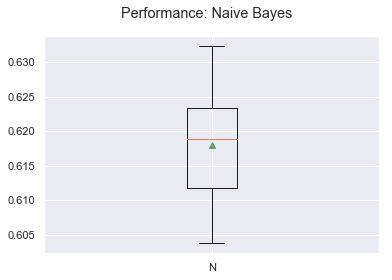

In [49]:
nbModel = Model('Naive Bayes',X,y,BernoulliNB())
nbModel.performance()

### Logistic Regression (Vanilla)

Model:		Vanilla Reg
CV Mean:	0.602116609593
CV Range:	0.0131922897921
Train Time:	0.0347900390625
CV Scores: 
[ 0.59602273  0.60318363  0.5997726   0.60238908  0.60921502]


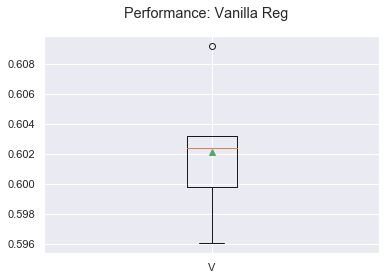

In [50]:
vanRegModelParams = {'C': 1e9,
               'penalty': 'l2'}
vanRegModel = Model('Vanilla Reg',X,y,LogisticRegression(),**vanRegModelParams)
vanRegModel.performance()

### Ridge

Model:		Ridge Reg
CV Mean:	0.602116544916
CV Range:	0.0131922897921
Train Time:	0.029314756393432617
CV Scores: 
[ 0.59602273  0.60318363  0.6003411   0.60182025  0.60921502]


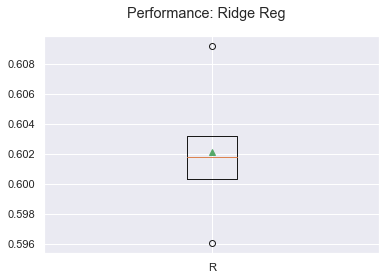

In [51]:
ridgeRegModelParams = {'C': .00029902,
               'penalty': 'l2'}
ridgeRegModel = Model('Ridge Reg',X,y,LogisticRegression(),**ridgeRegModelParams)
ridgeRegModel.performance()

### Lasso

Model:		Lasso Reg
CV Mean:	0.64930762804
CV Range:	0.0322136569219
Train Time:	0.02370285987854004
CV Scores: 
[ 0.65738636  0.63956794  0.63160887  0.66382253  0.65415245]


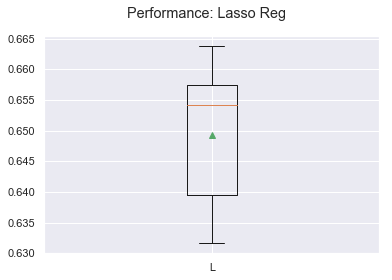

In [52]:
lassoRegModelParams = {'C':0.0954545,
               'penalty': 'l1'}
lassoRegModel = Model('Lasso Reg',X,y,LogisticRegression(),**lassoRegModelParams)
lassoRegModel.performance()

### KNN

Model:		KNN
CV Mean:	0.593131711969
CV Range:	0.0252390304408
Train Time:	0.014279842376708984
CV Scores: 
[ 0.60454545  0.58385446  0.57930642  0.60125142  0.5967008 ]


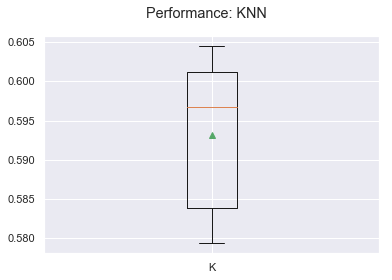

In [53]:
knnModelParams = {'n_neighbors': 4,
               'weights': 'distance'}
knnModel = Model('KNN',X,y,KNeighborsClassifier(),**knnModelParams)
knnModel.performance()

### Decision Tree

Model:		D Tree
CV Mean:	0.642482398928
CV Range:	0.0280672581963
Train Time:	0.06330704689025879
CV Scores: 
[ 0.64204545  0.65776009  0.63786242  0.62969283  0.64505119]


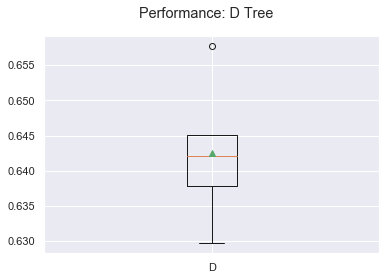

In [54]:
dtModelParams = {'max_features':12, 
                 'max_depth':9, 
                 'criterion':'entropy'}
dtModel = Model('D Tree',X,y,tree.DecisionTreeClassifier(),**dtModelParams)
dtModel.performance()

In [55]:
np.mean(dtModel.crossVal)

0.64248239892811365

### Random Forest

Model:		Random Forest
CV Mean:	0.652489702354
CV Range:	0.0138468762309
Train Time:	0.33475708961486816
CV Scores: 
[ 0.65340909  0.65150654  0.65719159  0.65699659  0.64334471]


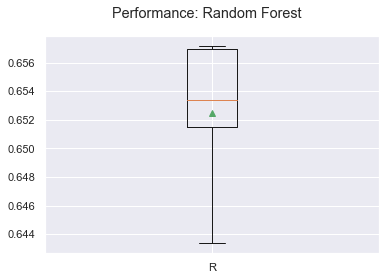

In [56]:
rfModelParams = {'n_estimators':22,
                 'max_depth':19,
                 'max_features':9,
                 'criterion':'entropy'}
rfModel = Model('Random Forest',X,y,ensemble.RandomForestClassifier(),**rfModelParams)
rfModel.performance()

### SVM

Model:		SVM
CV Mean:	0.600640437906
CV Range:	0.0367358250531
Train Time:	6.391637086868286
CV Scores: 
[ 0.60056818  0.58158044  0.587834    0.6149033   0.61831627]


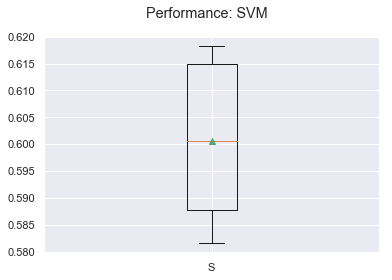

In [57]:
svmModelParams = {'C':4}
svmModel = Model('SVM',X,y,SVC(),**svmModelParams)
svmModel.performance()

### Gradient Boost

Model:		Gradient Boost
CV Mean:	0.679325656416
CV Range:	0.0178128280302
Train Time:	1.0810317993164062
CV Scores: 
[ 0.68125     0.67993178  0.68504832  0.68316268  0.66723549]


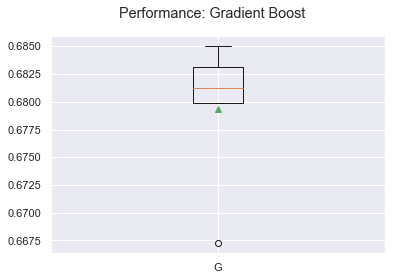

In [58]:
gbModelParams = {'n_estimators':128,
                 'max_depth':4,
                 'loss':'exponential'}
gbModel = Model('Gradient Boost',X,y,ensemble.GradientBoostingClassifier(),**gbModelParams)
gbModel.performance()

# Feature Selection

### PCA

In [59]:
pca = PCA(n_components=X.shape[1])
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=19, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

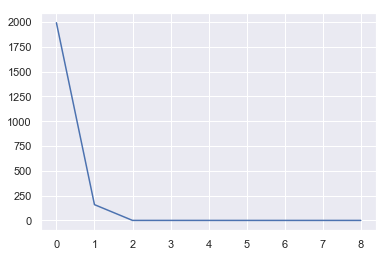

In [60]:
plt.plot(pca.explained_variance_[1:10])
plt.show()

In [61]:
pca2=PCA(n_components=2)
pca2out = pca2.fit_transform(X)
pca2.score

<bound method PCA.score of PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)>

### Lasso and Key Features

In [73]:
lrFeatSel = LogisticRegression(C=.01, penalty='l1')
lrFeatSel.fit(X,y)
coefDict = {}
for coef, feat in zip(lrFeatSel.coef_[0], X.columns):
    coefDict[feat] = coef

    filtCoefs = {f: c for f, c in coefDict.items() if c != 0.0}
lassoFeats = list(filtCoefs.keys())
sortedCoefs = sorted(filtCoefs.items(), 
                     key=operator.itemgetter(1))
sortedCoefs

[('CampaignLength', -0.013715272750967443),
 ('usd_goal_real', -1.7230506661717412e-05),
 ('num_category', 0.0023438445407564924),
 ('US', 0.13821916987200258),
 ('cat_Music', 0.13932849353901861)]

# Weaker Models on Feature Selection

### Naive Bayes

Model:		Naive Bayes PCA
CV Mean:	0.615875981632
CV Range:	0.0395903143334
Train Time:	2.9265899658203125
CV Scores: 
[ 0.61818182  0.5997726   0.61398522  0.63936291  0.60807736]


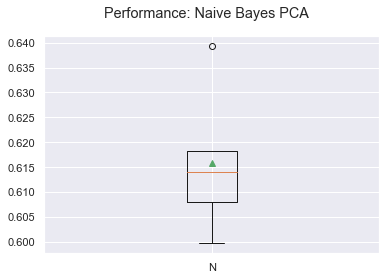

In [74]:
nbModelP = Model('Naive Bayes PCA',pca2out,y,SVC())
nbModelP.performance()

Model:		Naive Bayes Lasso
CV Mean:	0.601549980521
CV Range:	0.0333267363489
Train Time:	2.5965969562530518
CV Scores: 
[ 0.59715909  0.5884025   0.59295054  0.62172924  0.60750853]


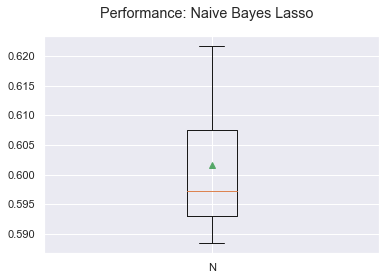

In [75]:
nbModelL = Model('Naive Bayes Lasso',X[lassoFeats],y,SVC())
nbModelL.performance()

,Name,CV Mean,CV Range,Time
0,Naive Bayes,0.618034,0.028634,0.013858
1,Naive Bayes PCA,0.615876,0.039590,2.926590
2,Naive Bayes Lasso,0.601550,0.033327,2.596597


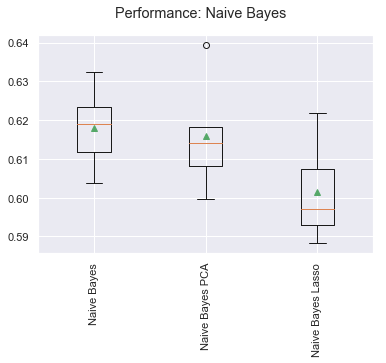

In [76]:
nbModel.fullCompareList([nbModelP,nbModelL])

### SVM

Model:		SVM PCA
CV Mean:	0.614510599669
CV Range:	0.0310595080331
Train Time:	3.7509970664978027
CV Scores: 
[ 0.61647727  0.60261512  0.61625924  0.63367463  0.60352673]


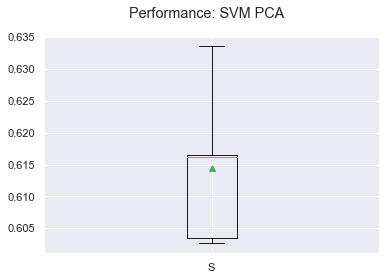

In [77]:
svmModelParamsP = {'C':2}
svmModelP = Model('SVM PCA',pca2out,y,SVC(),**svmModelParams)
svmModelP.performance()

Model:		SVM Lasso
CV Mean:	0.601777382821
CV Range:	0.0384423096948
Train Time:	3.393258810043335
CV Scores: 
[ 0.6         0.58158044  0.59522456  0.62002275  0.61205916]


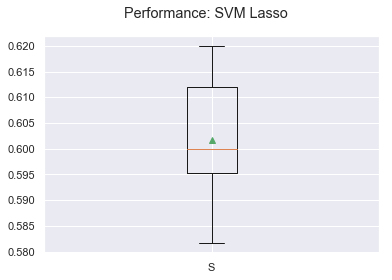

In [78]:
svmModelParamsL = {'C':2}
svmModelL = Model('SVM Lasso',X[lassoFeats],y,SVC(),**svmModelParams)
svmModelL.performance()

,Name,CV Mean,CV Range,Time,CV Fold 1,CV Fold 2,CV Fold 3,CV Fold 4,CV Fold 5
0,SVM,0.600640,0.036736,6.391637,0.600568,0.581580,0.587834,0.614903,0.618316
1,SVM PCA,0.614511,0.031060,3.750997,0.616477,0.602615,0.616259,0.633675,0.603527
2,SVM Lasso,0.601777,0.038442,3.393259,0.600000,0.581580,0.595225,0.620023,0.612059


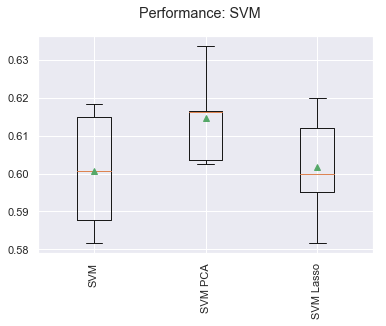

In [79]:
svmModel.fullCompareList([svmModelP,svmModelL],folds=True)

# Model Comparisons

### All Together

,Name,CV Mean,CV Range,Time
0,Gradient Boost,0.679326,0.017813,1.081032
1,D Tree,0.642482,0.028067,0.063307
2,Random Forest,0.652490,0.013847,0.334757
3,Lasso Reg,0.649308,0.032214,0.023703
4,Naive Bayes,0.618034,0.028634,0.013858
5,SVM PCA,0.614511,0.031060,3.750997
6,Vanilla Reg,0.602117,0.013192,0.034790
7,Ridge Reg,0.602117,0.013192,0.029315


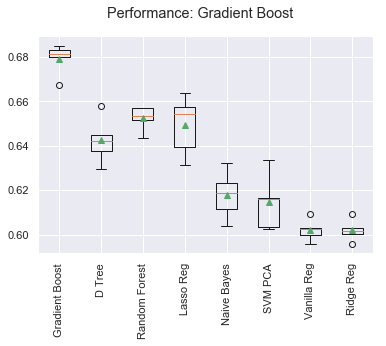

In [80]:
gbModel.fullCompareList([dtModel,
                         rfModel,
                         lassoRegModel,
                         nbModel,
                         svmModelP,
                         vanRegModel,
                         ridgeRegModel
                         ])

### Low Performers

,Name,CV Mean,CV Range,Time,CV Fold 1,CV Fold 2,CV Fold 3,CV Fold 4,CV Fold 5
0,Naive Bayes,0.618034,0.028634,0.013858,0.632386,0.611711,0.603752,0.623436,0.618885
1,SVM PCA,0.614511,0.031060,3.750997,0.616477,0.602615,0.616259,0.633675,0.603527
2,Vanilla Reg,0.602117,0.013192,0.034790,0.596023,0.603184,0.599773,0.602389,0.609215
3,Ridge Reg,0.602117,0.013192,0.029315,0.596023,0.603184,0.600341,0.601820,0.609215


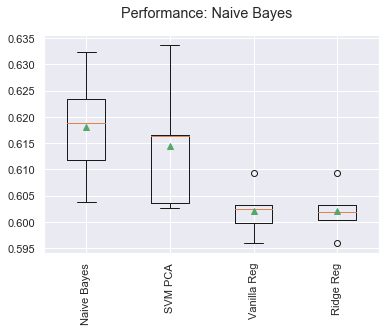

In [81]:
nbModel.fullCompareList([svmModelP,
                         vanRegModel,
                         ridgeRegModel
                         ],folds=True)

### High Performers

,Name,CV Mean,CV Range,Time
0,Gradient Boost,0.679326,0.017813,1.081032
1,D Tree,0.642482,0.028067,0.063307
2,Random Forest,0.652490,0.013847,0.334757
3,Lasso Reg,0.649308,0.032214,0.023703


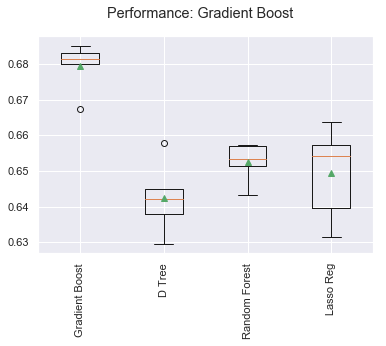

In [82]:
gbModel.fullCompareList([dtModel,
                         rfModel,
                         lassoRegModel])